In [1]:
# Celda 1: Instalación de dependencias
!pip install faker ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!

In [1]:
# --- CELDA 1: GENERADOR DE DATOS REALISTA (DENUE + ROLES) ---
import sqlite3
import random
import pandas as pd
import numpy as np
from faker import Faker
from datetime import date, timedelta

# --- CONFIGURACIÓN ---
ARCHIVO_CSV = "tiendas2.csv" # Tu archivo real
NUM_TIENDAS_OBJETIVO = 300       # Tiendas con transporte
NUM_EMPLEADOS_TOTAL = 2500       # Universo total
USUARIOS_TRANSPORTE = 1065       # Nuestro target

DB_NAME = "oxxo_demo.db"
fake = Faker('es_MX')
Faker.seed(42)
random.seed(42)
np.random.seed(42)

print(f"--- GENERANDO ESCENARIO FINAL (DATOS REALES + SIMULACIÓN) ---")

# 1. CARGA Y PREPARACIÓN
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Limpieza de tablas
cursor.execute('DROP TABLE IF EXISTS Tiendas')
cursor.execute('''CREATE TABLE Tiendas (id_tienda TEXT PRIMARY KEY, nombre TEXT, latitud REAL, longitud REAL, tipo_horario TEXT, tiene_transporte INTEGER)''')
cursor.execute('DROP TABLE IF EXISTS Empleados')
cursor.execute('''CREATE TABLE Empleados (id_empleado TEXT PRIMARY KEY, nombre_completo TEXT, puesto TEXT, latitud_casa REAL, longitud_casa REAL, turno_preferido TEXT, turnos_disponibles TEXT, usa_transporte INTEGER)''')
cursor.execute('DROP TABLE IF EXISTS Ventas_Historicas')
cursor.execute('''CREATE TABLE Ventas_Historicas (id_venta INTEGER PRIMARY KEY AUTOINCREMENT, id_tienda TEXT, fecha TEXT, turno TEXT, total_venta REAL)''')

# 2. PROCESAR TIENDAS DEL DENUE
try:
    df_real = pd.read_csv(ARCHIVO_CSV, encoding='latin-1')
    df_real = df_real[
        (df_real['Latitud'] < 29) &
        (df_real['Longitud'] > -106.3)
    ]
except:
    df_real = pd.read_csv(ARCHIVO_CSV, encoding='utf-8')

# Detectar columnas dinámicamente
col_lat = [c for c in df_real.columns if 'Latitud' in c][0]
col_lon = [c for c in df_real.columns if 'Longitud' in c][0]
col_nom = [c for c in df_real.columns if 'Nombre' in c][0]

# Seleccionar 300 tiendas para el programa de transporte
df_tiendas_select = df_real.sample(n=min(len(df_real), NUM_TIENDAS_OBJETIVO), random_state=42)
coords_reales = []
tiendas_data = []

for idx, row in df_tiendas_select.iterrows():
    id_t = f"T{idx}"
    nom = str(row[col_nom]).replace("OXXO SUC ", "").strip()
    lat, lon = float(row[col_lat]), float(row[col_lon])
    # Asignamos atributos
    tipo_h = '24h' if random.random() < 0.3 else '18h'
    tiene_t = 1 # Todas estas tienen transporte

    tiendas_data.append((id_t, nom, lat, lon, tipo_h, tiene_t))
    coords_reales.append((lat, lon))

cursor.executemany("INSERT INTO Tiendas VALUES (?,?,?,?,?,?)", tiendas_data)

# 3. GENERAR EMPLEADOS (CON JERARQUÍA LÓGICA)
print("Generando plantilla de empleados...")
emp_data = []
roles = ['Lider', 'Encargado', 'Auxiliar']
# Pesos ajustados: Necesitamos suficientes jefes para 300 tiendas
pesos_roles = [0.25, 0.30, 0.45]
turnos_ops = ['Matutino', 'Vespertino', 'Nocturno']

# Flags para identificar a los 1065 del transporte
flags_trans = [1]*USUARIOS_TRANSPORTE + [0]*(NUM_EMPLEADOS_TOTAL - USUARIOS_TRANSPORTE)
random.shuffle(flags_trans)

for i in range(NUM_EMPLEADOS_TOTAL):
    id_e = f"E{i:04d}"
    # Sembrar empleado cerca de una tienda real (0.5km - 5km) para realismo
    cent_lat, cent_lon = random.choice(coords_reales)
    dev_lat = random.uniform(-0.03, 0.03)
    dev_lon = random.uniform(-0.03, 0.03)

    puesto = random.choices(roles, weights=pesos_roles, k=1)[0]

    # Reglas de Turno Judith
    if puesto == 'Lider':
        pref, disp = 'Matutino', 'Matutino,Vespertino'
    elif puesto == 'Encargado':
        pref, disp = 'Vespertino', 'Matutino,Vespertino,Nocturno'
    else:
        pref = random.choice(turnos_ops)
        disp = ",".join(random.sample(turnos_ops, random.randint(1,3)))

    emp_data.append((id_e, fake.name(), puesto, cent_lat+dev_lat, cent_lon+dev_lon, pref, disp, flags_trans[i]))

cursor.executemany("INSERT INTO Empleados VALUES (?,?,?,?,?,?,?,?)", emp_data)

# 4. GENERAR VENTAS (6 MESES)
print("Simulando 6 meses de operación (ventas)...")
batch_ventas = []
fecha_ini = date(2023, 1, 1)
# Solo generamos para las tiendas activas para ahorrar tiempo
for i in range(180): # 180 días
    dia = fecha_ini + timedelta(days=i)
    str_dia = dia.strftime("%Y-%m-%d")
    es_fin = dia.weekday() >= 5

    for t in tiendas_data:
        # Ventas aleatorias realistas
        for turno in turnos_ops:
            vta = random.uniform(1000, 3500)
            if es_fin: vta *= 1.4
            if turno == 'Nocturno': vta *= 0.7
            batch_ventas.append((t[0], str_dia, turno, round(vta, 2)))

    if len(batch_ventas) > 50000:
        cursor.executemany("INSERT INTO Ventas_Historicas (id_tienda, fecha, turno, total_venta) VALUES (?,?,?,?)", batch_ventas)
        batch_ventas = []

if batch_ventas:
    cursor.executemany("INSERT INTO Ventas_Historicas (id_tienda, fecha, turno, total_venta) VALUES (?,?,?,?)", batch_ventas)

conn.commit()
conn.close()
print("✅ Datos listos. (Recuerda correr la celda de IA para actualizar JSON)")

--- GENERANDO ESCENARIO FINAL (DATOS REALES + SIMULACIÓN) ---
Generando plantilla de empleados...
Simulando 6 meses de operación (ventas)...
✅ Datos listos. (Recuerda correr la celda de IA para actualizar JSON)


In [2]:
# --- CELDA INTERMEDIA: MACHINE LEARNING Y PREDICCIÓN ---
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import json
import warnings

# Ignorar advertencias de nombres de columnas
warnings.filterwarnings("ignore")

print("--- ENTRENANDO MODELO DE DEMANDA (IA) ---")

# 1. Conectar a la BD SQLite
engine = create_engine("sqlite:///oxxo_demo.db")

# 2. Leer datos
try:
    df_ventas = pd.read_sql("SELECT * FROM Ventas_Historicas", engine)
    df_tiendas = pd.read_sql("SELECT id_tienda, tipo_horario FROM Tiendas", engine)

    if df_ventas.empty:
        raise ValueError("La tabla de ventas está vacía. Corre la Celda 1 primero.")

    # Mapa para saber si es 18h o 24h rápido
    mapa_horarios = dict(zip(df_tiendas.id_tienda, df_tiendas.tipo_horario))

    print(f"Datos cargados: {len(df_ventas)} registros de ventas.")

    # 3. Preparar datos para el modelo
    df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
    df_ventas['dia_semana'] = df_ventas['fecha'].dt.dayofweek
    df_ventas['es_quincena'] = df_ventas['fecha'].dt.day.isin([15, 30, 31, 14, 29]).astype(int)

    le_tienda = LabelEncoder()
    df_ventas['tienda_cod'] = le_tienda.fit_transform(df_ventas['id_tienda'])

    le_turno = LabelEncoder()
    df_ventas['turno_cod'] = le_turno.fit_transform(df_ventas['turno'])

    features = ['tienda_cod', 'turno_cod', 'dia_semana', 'es_quincena']
    X = df_ventas[features]
    y = df_ventas['total_venta']

    # 4. Entrenar
    print("Entrenando Random Forest...")
    modelo = RandomForestRegressor(n_estimators=50, random_state=42)
    modelo.fit(X, y)
    print("¡Modelo entrenado!")

    # 5. Predecir Demanda Futura (Próximo Lunes)
    print("Generando predicciones...")
    tiendas_unicas = df_ventas['id_tienda'].unique()
    turnos_unicos = ['Matutino', 'Vespertino', 'Nocturno']
    predicciones = {}

    for id_tienda in tiendas_unicas:
        predicciones[id_tienda] = {}
        # Recuperamos horario
        tipo_horario = mapa_horarios.get(id_tienda, '24h')

        for turno in turnos_unicos:
            # REGLA DE NEGOCIO: Si es Nocturno y la tienda es 18h, demanda es 0
            if turno == 'Nocturno' and tipo_horario == '18h':
                predicciones[id_tienda][turno] = 0
                continue

            try:
                tienda_num = le_tienda.transform([id_tienda])[0]
                turno_num = le_turno.transform([turno])[0]

                # Predicción: Tienda, Turno, Lunes (0), No Quincena (0)
                venta_predicha = modelo.predict([[tienda_num, turno_num, 0, 0]])[0]

                # Convertir dinero a empleados (Regla simple)
                empleados = 0
                if venta_predicha > 100:
                    empleados = int(venta_predicha / 800) + 1
                    if empleados > 3: empleados = 3

                predicciones[id_tienda][turno] = empleados
            except:
                predicciones[id_tienda][turno] = 1 # Default por seguridad

    # 6. Guardar JSON
    with open('demanda_predicha.json', 'w') as f:
        json.dump(predicciones, f, indent=4)

    print("¡Listo! Archivo 'demanda_predicha.json' generado correctamente.")

except Exception as e:
    print(f"❌ ERROR: {e}")
    print("Asegúrate de haber corrido la Celda 1 (Generador) primero.")

--- ENTRENANDO MODELO DE DEMANDA (IA) ---
Datos cargados: 162000 registros de ventas.
Entrenando Random Forest...
¡Modelo entrenado!
Generando predicciones...
¡Listo! Archivo 'demanda_predicha.json' generado correctamente.


Generando Mapa de Distribución (Topología)...
Tiendas Reales (DENUE): 300
Empleados Simulados (Transporte): 1065


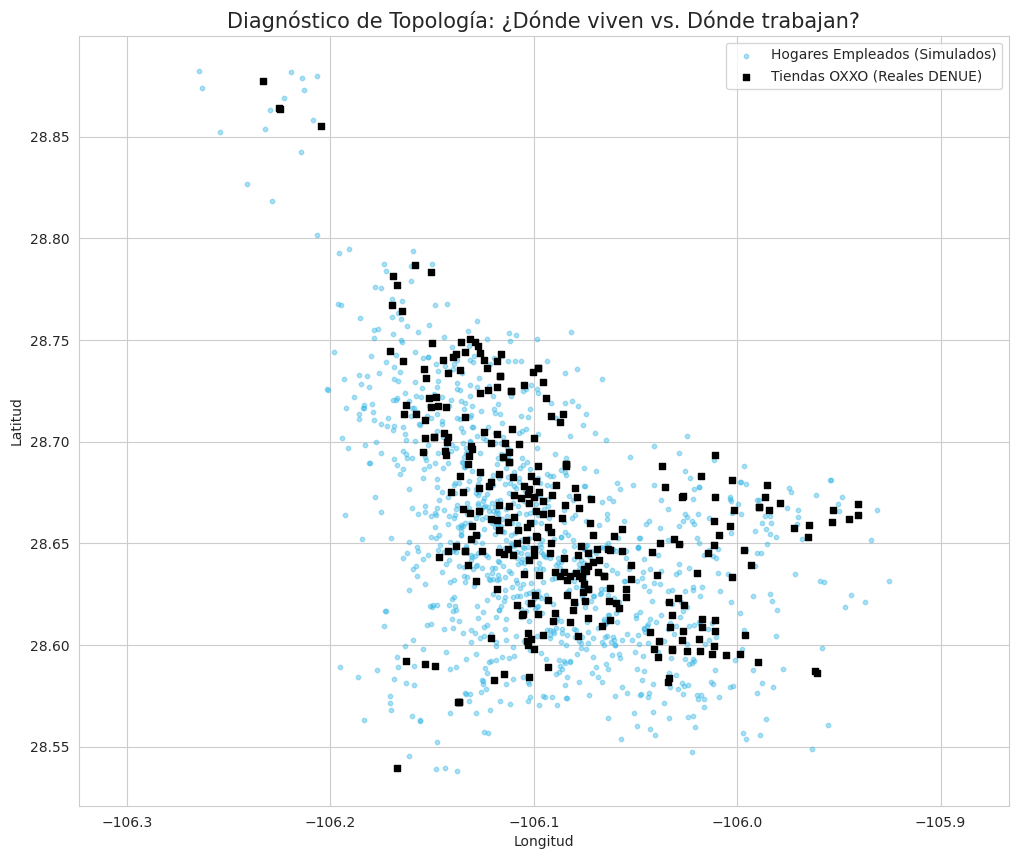

Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.


In [ ]:
# --- CELDA DE DIAGNÓSTICO: DISTRIBUCIÓN GEOGRÁFICA ---
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Generando Mapa de Distribución (Topología)...")

# 1. Cargar Datos
conn = sqlite3.connect("oxxo_demo.db")
df_t = pd.read_sql("SELECT latitud, longitud FROM Tiendas", conn)
df_e = pd.read_sql("SELECT latitud_casa, longitud_casa FROM Empleados WHERE usa_transporte = 1", conn)
conn.close()

print(f"Tiendas Reales (DENUE): {len(df_t)}")
print(f"Empleados Simulados (Transporte): {len(df_e)}")

# 2. Configurar Gráfico
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Capa 1: Empleados (Puntos azules pequeños y transparentes para ver densidad)
plt.scatter(df_e['longitud_casa'], df_e['latitud_casa'],
            c='#33B5E5', s=10, alpha=0.4, label='Hogares Empleados (Simulados)')

# Capa 2: Tiendas (Puntos rojos sólidos)
plt.scatter(df_t['longitud'], df_t['latitud'],
            c='black', s=15, marker='s', label='Tiendas OXXO (Reales DENUE)')

# Estética
plt.title("Diagnóstico de Topología: ¿Dónde viven vs. Dónde trabajan?", fontsize=15)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.axis('equal') # IMPORTANTE: Para que el mapa no se vea estirado

# Guardar y Mostrar
plt.savefig('diagnostico_topologia.png', dpi=150)
plt.show()

print("Verifica la imagen: Los puntos azules deberían formar una 'nube' alrededor de los puntos negros.")

--- EJECUTANDO OPTIMIZACIÓN FINAL ---
Calculando escenario actual...
Optimizando asignaciones...
  -> Resolviendo...
  -> Estado: OPTIMAL

RESULTADOS FINALES
Empleados Asignados: 1065 de 1065
Gasto Actual:      $7,564,994.45
Gasto Propuesta:   $846,090.73
AHORRO TOTAL:      $6,718,903.73
Gráfica guardada: resultado_final.png


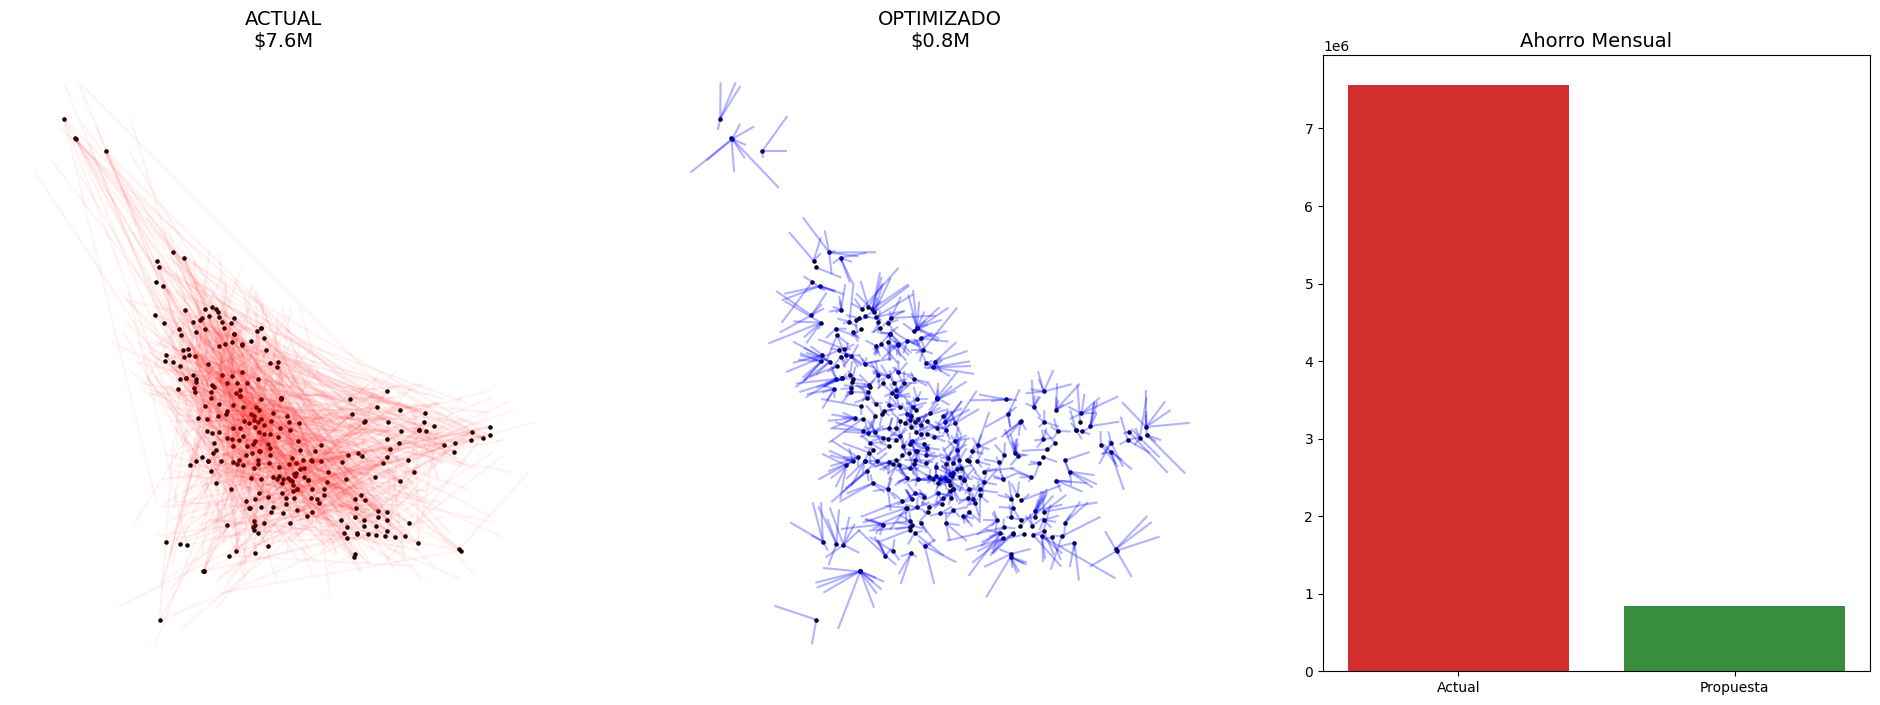

In [3]:
# --- CELDA FINAL: ALGORITMO ROBUSTO (SOFT CONSTRAINTS) ---
import json
import pandas as pd
import numpy as np
import random
from sqlalchemy import create_engine
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

print("--- EJECUTANDO OPTIMIZACIÓN FINAL ---")

# 1. CARGA
engine = create_engine("sqlite:///oxxo_demo.db")
df_emp = pd.read_sql("SELECT * FROM Empleados WHERE usa_transporte = 1", engine)
df_tiendas = pd.read_sql("SELECT * FROM Tiendas WHERE tiene_transporte = 1", engine)
try:
    with open('demanda_predicha.json', 'r') as f: demanda_predicha = json.load(f)
except: demanda_predicha = {}

def calcular_distancia(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1); dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

emps = df_emp.to_dict('records')
tiendas = df_tiendas.to_dict('records')

# --- ESCENARIO CAOS (SIMULACIÓN ACTUAL) ---
print("Calculando escenario actual...")
dist_caos = []
coords_caos = []
for e in emps:
    # Simulamos que actualmente van lejos
    t = random.choice(tiendas)
    # Forzamos una distancia media-larga para reflejar la ineficiencia
    d = calcular_distancia(e['latitud_casa'], e['longitud_casa'], t['latitud'], t['longitud'])
    if d < 3: d += random.uniform(3, 8)
    dist_caos.append(d)
    coords_caos.append((e['latitud_casa'], e['longitud_casa'], t['latitud'], t['longitud']))

# --- OPTIMIZACIÓN ---
print("Optimizando asignaciones...")
model = cp_model.CpModel()
vars_x = {} # x[empleado, tienda, turno]

# Pesos de Penalización (Soft Constraints)
PENALTY_DISTANCIA = 1
PENALTY_NO_PREFERENCIA = 50
PENALTY_SIN_LIDER = 50000    # Doloroso, pero no mortal
PENALTY_SIN_ENCARGADO = 50000
REWARD_ASIGNACION = 1000     # Premio por asignar a alguien

# Crear Variables
obj_terms = []
for i, e in enumerate(emps):
    turnos_ok = e['turnos_disponibles'].split(',')
    # Radio amplio para asegurar factibilidad
    radio = 35 if e['puesto'] != 'Auxiliar' else 15

    for j, t in enumerate(tiendas):
        d = calcular_distancia(e['latitud_casa'], e['longitud_casa'], t['latitud'], t['longitud'])
        if d > radio: continue

        for turno in ['Matutino', 'Vespertino', 'Nocturno']:
            if turno in turnos_ok:
                x = model.NewBoolVar(f'x_{i}_{j}_{turno}')
                vars_x[(i, j, turno)] = x

                # Costo Base
                costo = int(d * PENALTY_DISTANCIA)
                if turno != e['turno_preferido']: costo += PENALTY_NO_PREFERENCIA

                # Función: Minimizar (Costo - Recompensa)
                obj_terms.append(x * (costo - REWARD_ASIGNACION))

# 1. Restricción Dura: 1 Empleado = Max 1 Turno
for i in range(len(emps)):
    model.Add(sum([v for (ei, tj, tu), v in vars_x.items() if ei == i]) <= 1)

# 2. Restricciones Flexibles por Tienda
tienda_vars = {}
for (i, j, turno), v in vars_x.items():
    if j not in tienda_vars: tienda_vars[j] = {'all': [], 'lider': [], 'encargado': []}
    tienda_vars[j]['all'].append(v)
    if emps[i]['puesto'] == 'Lider': tienda_vars[j]['lider'].append(v)
    if emps[i]['puesto'] == 'Encargado': tienda_vars[j]['encargado'].append(v)

for j, vars_dict in tienda_vars.items():
    # A. Capacidad Máxima (Dura) - Para que no se vea el amontonadero
    model.Add(sum(vars_dict['all']) <= 6) # Max 6 personas totales (aprox 2 por turno)

    # B. Jerarquía (Flexible/Soft)
    # En lugar de obligar (>=1), creamos variables de "Falta"
    falta_lider = model.NewBoolVar(f'falta_lider_{j}')
    falta_encargado = model.NewBoolVar(f'falta_encargado_{j}')

    # Lógica: Si Sum(Lideres) >= 1, entonces falta_lider puede ser 0. Si es 0, falta_lider TIENE que ser 1.
    # (Simplificado: Penalizamos si la suma es 0)
    model.Add(sum(vars_dict['lider']) >= 1).OnlyEnforceIf(falta_lider.Not())
    # Si no hay líder, pagamos la multa en la función objetivo
    obj_terms.append(falta_lider * PENALTY_SIN_LIDER)

    model.Add(sum(vars_dict['encargado']) >= 1).OnlyEnforceIf(falta_encargado.Not())
    obj_terms.append(falta_encargado * PENALTY_SIN_ENCARGADO)

model.Minimize(sum(obj_terms))

print("  -> Resolviendo...")
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 300
solver.parameters.num_search_workers = 8
status = solver.Solve(model)
print(f"  -> Estado: {solver.StatusName(status)}")

# --- RESULTADOS Y GRÁFICOS ---
coords_opt = []
dist_opt = []

if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    for (i, j, turno), v in vars_x.items():
        if solver.Value(v) == 1:
            e, t = emps[i], tiendas[j]
            d = calcular_distancia(e['latitud_casa'], e['longitud_casa'], t['latitud'], t['longitud'])
            dist_opt.append(d)
            coords_opt.append((e['latitud_casa'], e['longitud_casa'], t['latitud'], t['longitud']))

# Finanzas
def calcular_costo(kms):
    total = 0
    for d in kms:
        if d < 1.5: continue
        costo = 40 + (d * 10)
        costo = max(50, min(200, costo)) # Tope $50-$200
        total += (costo * 2 * 26) # Ida+Vuelta, 26 días
    return total

gasto_caos = calcular_costo(dist_caos)
gasto_opt = calcular_costo(dist_opt)
ahorro = gasto_caos - gasto_opt

print("\n" + "="*40)
print(f"RESULTADOS FINALES")
print(f"Empleados Asignados: {len(coords_opt)} de {len(emps)}")
print(f"Gasto Actual:      ${gasto_caos:,.2f}")
print(f"Gasto Propuesta:   ${gasto_opt:,.2f}")
print(f"AHORRO TOTAL:      ${ahorro:,.2f}")
print("="*40)

# Gráficos
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
# Mapa Rojo
ax[0].set_title(f"ACTUAL\n${gasto_caos/1e6:.1f}M", fontsize=14)
for c in coords_caos: ax[0].plot([c[1], c[3]], [c[0], c[2]], c='red', alpha=0.05)
ax[0].scatter([t['longitud'] for t in tiendas], [t['latitud'] for t in tiendas], c='black', s=5)
ax[0].axis('off')

# Mapa Azul
ax[1].set_title(f"OPTIMIZADO\n${gasto_opt/1e6:.1f}M", fontsize=14)
for c in coords_opt: ax[1].plot([c[1], c[3]], [c[0], c[2]], c='blue', alpha=0.3)
ax[1].scatter([t['longitud'] for t in tiendas], [t['latitud'] for t in tiendas], c='black', s=5)
ax[1].axis('off')

# Barras
ax[2].bar(['Actual', 'Propuesta'], [gasto_caos, gasto_opt], color=['#D32F2F', '#388E3C'])
ax[2].set_title("Ahorro Mensual", fontsize=14)
plt.savefig('resultado_final.png', dpi=150)
print("Gráfica guardada: resultado_final.png")

--- SISTEMA DE ASIGNACIÓN PARA RH (PROTOTIPO) ---
Simulando llegada de candidato...
📍 Ubicación Candidato: 28.6228, -106.0438

       REPORTE DE ASIGNACIÓN IDEAL
Candidato ubicado en: 28.6228, -106.0438

TOP 3 TIENDAS RECOMENDADAS:
1. 50POK KOP CUF
   Distancia: 1.04 km
   Transporte Disponible: ✅ SÍ
   Costo Estimado para OXXO: $0 (Camina)
------------------------------
2. 50F6B NOBLE CUF
   Distancia: 1.06 km
   Transporte Disponible: ✅ SÍ
   Costo Estimado para OXXO: $0 (Camina)
------------------------------
3. 50OSR SAN RAFAEL CUF
   Distancia: 1.19 km
   Transporte Disponible: ✅ SÍ
   Costo Estimado para OXXO: $0 (Camina)
------------------------------

RECOMENDACIÓN AL RECLUTADOR:
🌟 ¡CONTRATACIÓN IDEAL! Asignar a 50POK KOP CUF. Costo cero de transporte.


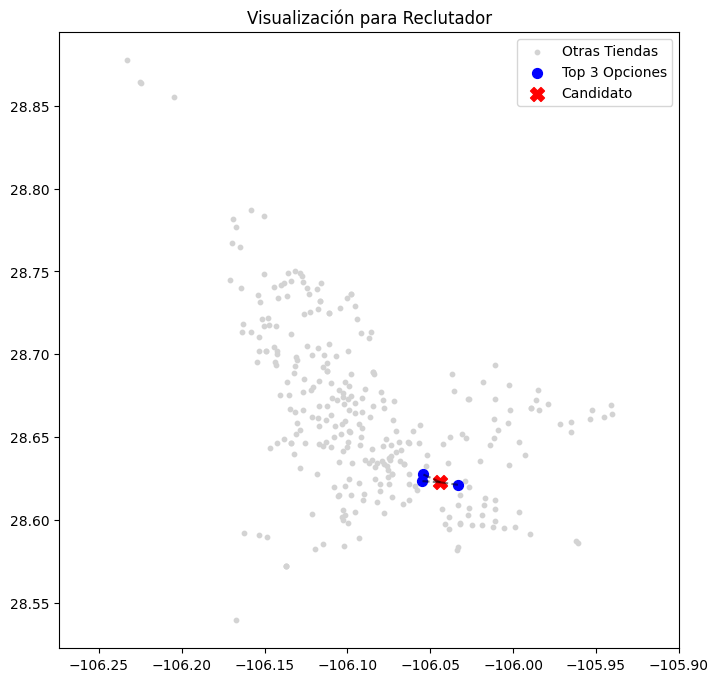

In [4]:
# --- PROTOTIPO: HERRAMIENTA DE RECLUTAMIENTO INTELIGENTE ---
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- SISTEMA DE ASIGNACIÓN PARA RH (PROTOTIPO) ---")

# 1. SIMULACIÓN: LLEGA UN CANDIDATO
# (En la vida real, esto vendría de un formulario web)
print("Simulando llegada de candidato...")

# Coordenadas aleatorias en Chihuahua (simulando su casa)
# Centro aprox de Chihuahua: 28.63, -106.08
lat_candidato = 28.6353 + np.random.uniform(-0.05, 0.05)
lon_candidato = -106.0889 + np.random.uniform(-0.05, 0.05)

print(f"📍 Ubicación Candidato: {lat_candidato:.4f}, {lon_candidato:.4f}")

# 2. CONECTAR A LA BASE DE DATOS EXISTENTE
conn = sqlite3.connect("oxxo_demo.db")
df_tiendas = pd.read_sql("SELECT * FROM Tiendas", conn)
conn.close()

# 3. LÓGICA DE RECOMENDACIÓN
def calcular_distancia(lat1, lon1, lat2, lon2):
    R = 6371 # Radio tierra km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculamos distancia a LAS 620 TIENDAS
df_tiendas['distancia_km'] = df_tiendas.apply(
    lambda row: calcular_distancia(lat_candidato, lon_candidato, row['latitud'], row['longitud']), axis=1
)

# 4. REGLAS DE NEGOCIO PARA EL RANKING
# Queremos las más cercanas.
# Si la distancia es > 3km, preferimos que la tienda tenga transporte.
df_tiendas = df_tiendas.sort_values('distancia_km')

# Tomamos el TOP 3
top_3 = df_tiendas.head(3)

# 5. IMPRIMIR "TICKET" PARA RH
print("\n" + "="*40)
print("       REPORTE DE ASIGNACIÓN IDEAL")
print("="*40)
print(f"Candidato ubicado en: {lat_candidato:.4f}, {lon_candidato:.4f}\n")

print("TOP 3 TIENDAS RECOMENDADAS:")
rank = 1
for idx, row in top_3.iterrows():
    nombre = row['nombre']
    dist = row['distancia_km']
    tiene_trans = "✅ SÍ" if row['tiene_transporte'] == 1 else "❌ NO"

    # Análisis de costo
    costo_est = "$0 (Camina)" if dist < 1.5 else f"${max(50, 40 + dist*10):.0f} (Transporte)"

    print(f"{rank}. {nombre}")
    print(f"   Distancia: {dist:.2f} km")
    print(f"   Transporte Disponible: {tiene_trans}")
    print(f"   Costo Estimado para OXXO: {costo_est}")
    print("-" * 30)
    rank += 1

print("\nRECOMENDACIÓN AL RECLUTADOR:")
mejor_opcion = top_3.iloc[0]
if mejor_opcion['distancia_km'] < 1.5:
    print(f"🌟 ¡CONTRATACIÓN IDEAL! Asignar a {mejor_opcion['nombre']}. Costo cero de transporte.")
elif mejor_opcion['tiene_transporte'] == 1:
    print(f"✅ Asignar a {mejor_opcion['nombre']}. Requiere transporte, pero la ruta ya existe.")
else:
    print(f"⚠️ PRECAUCIÓN. La tienda más cercana está a {mejor_opcion['distancia_km']:.1f}km y NO tiene servicio. Evaluar costo de bono.")

# 6. VISUALIZACIÓN RÁPIDA (EL MAPITA)
plt.figure(figsize=(8, 8))
# Todas las tiendas (gris)
plt.scatter(df_tiendas['longitud'], df_tiendas['latitud'], c='lightgray', s=10, label='Otras Tiendas')
# Top 3 (Azul)
plt.scatter(top_3['longitud'], top_3['latitud'], c='blue', s=50, label='Top 3 Opciones')
# Candidato (Rojo Grande)
plt.scatter(lon_candidato, lat_candidato, c='red', marker='X', s=100, label='Candidato')

# Dibujar líneas
for idx, row in top_3.iterrows():
    plt.plot([lon_candidato, row['longitud']], [lat_candidato, row['latitud']], 'k--', alpha=0.5)

plt.title("Visualización para Reclutador")
plt.legend()
plt.axis('equal')
plt.show()